<a href="https://colab.research.google.com/github/yfwang09/ShElastic/blob/master/examples/Case06-Hydrogel_deformation_test_case_with_penalty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hydrogel Indentation Test Case

In this notebook, we develop a test case for hydrogel particle indentation test with two opposite sphere indenter. We first assume the indenter is rigid.

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as spm
from scipy.sparse.linalg import lsqr, spsolve
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import minimize, Bounds, brute, approx_fprime
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import sys, time, os
from itertools import permutations
import pyshtools

sys.path.append('..')
from shelastic.shutil import SphCoord_to_CartCoord, CartCoord_to_SphCoord, GLQCartCoord
from shelastic.shutil import SHCilmToVector, SHVectorToCilm, SHVec2mesh, SHmesh2Vec
from shelastic.shutil import TransMat, l_coeffs, m_coeffs, LM_list, lmk2K, K2lmk
from shelastic.shbv   import generate_submat, Uvec2Tvec, Tvec2Uvec
from shelastic.shvis  import plotfv, vismesh, visSHVec, visSH3d
from shelastic.sphere_utils import loadCoeffs, arbitrary_force, Ur_interp
from shelastic.sphere_utils import usurf2umesh, dumesh_dus, usurf2vec
from shelastic.sphere_utils import Tvec2Tres, usurf2dr2, calculateTfv, genSmat, genLmat, grad_usurf2dr2

## Set up parameters for calculation

In [2]:
######### Do not change below unless you know what you are doing ###############
# Data file name
shapename = 'indent'
plot_figure = True

# Material properties
mu0 = 1401/3
nu0 = 0.499
R = 3.7
r = 0.5
d = 0.3

# Spherical Harmonics Analysis Settings
lJmax = 60; lKmax = lJmax; lmax_plot = 60;

# settings for loading \hat{U}, \hat{T} coefficients
Cmat, Dmat = loadCoeffs(mu0, nu0, lJmax, 'reg')

Integrating modes to a matrix
11163 11163
Integrating modes to a matrix
11163 11163


## Define indentation depth and contact region

In [3]:
d0 = d/R
R0 = R/R
r0 = r/R
Rs = 1./(1./R0+1./r0)
Es = 1./((1-.5**2)/3)
F  = 4/3 * Es * (Rs**.5) * (d0**1.5)
a  = np.cbrt(3*F*Rs/4/Es)
p0 = 3*F/2/np.pi/a**2

print(Rs*R, Es*mu0, p0*mu0, a*R)

0.44047619047619035 1868.0 981.4233878062707 0.3635145899999848


5.8356902589989295 0.10185200914609197 0.9948175665822556
[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 5.87785252e-01  8.09016994e-01  0.00000000e+00]
 [ 9.51056516e-01  3.09016994e-01  0.00000000e+00]
 [ 9.51056516e-01 -3.09016994e-01  0.00000000e+00]
 [ 5.87785252e-01 -8.09016994e-01  0.00000000e+00]
 [ 1.22464680e-16 -1.00000000e+00  0.00000000e+00]
 [-5.87785252e-01 -8.09016994e-01  0.00000000e+00]
 [-9.51056516e-01 -3.09016994e-01  0.00000000e+00]
 [-9.51056516e-01  3.09016994e-01  0.00000000e+00]
 [-5.87785252e-01  8.09016994e-01  0.00000000e+00]]


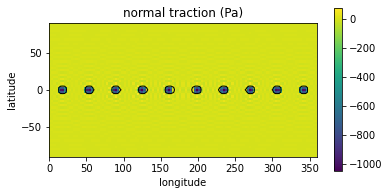

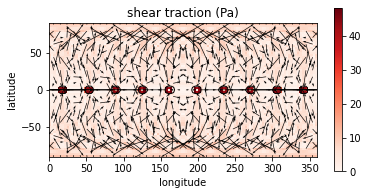

In [4]:
N = GLQCartCoord(lJmax)
X0 = N
lKmax = lJmax

dtheta = np.arctan(a/((R0+r0-d0)-np.sqrt(r0**2-a**2)))
cosdt  = np.cos(dtheta)
print(np.rad2deg(dtheta), dtheta, cosdt)

pL = np.array([0,-1, 0])
pR = np.array([0, 1, 0])

cos_XpL = np.dot(X0, pL)
cos_XpR = np.dot(X0, pR)

cLind = cos_XpL > cosdt
cRind = cos_XpR > cosdt

tS = np.arange(0, 1, 0.1)*np.pi*2
pS = np.vstack([np.sin(tS), np.cos(tS), 0*tS]).T
print(pS)

T0mesh = np.zeros_like(X0)
for i in range(tS.size):
    cSind = np.dot(X0, pS[i, :]) > cosdt
    T0mesh[cSind, :] = -(p0 * np.sqrt(1 - R0**2*(1-np.dot(X0[cSind, :], pS[i, :])**2)/(R0**2*(1-cosdt**2))))[:, None] * pS[i, :][None, :]
T0vec = SHmesh2Vec(T0mesh)
# print(T0mesh[np.nonzero(T0mesh)])

Vr, Vtheta, Vphi = CartCoord_to_SphCoord(X0[...,0], X0[...,1], X0[...,2])
LONS = np.rad2deg(Vphi).reshape(lmax_plot+1, 2*lmax_plot+2)
LATS = 90 - np.rad2deg(Vtheta).reshape(lmax_plot+1, 2*lmax_plot+2)
if plot_figure:
    fig, axs = visSHVec(T0vec*mu0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, show=False,
                        config_quiver=(2, 3, 'k', 100), lonshift=180, figsize=(6,3))
    axs[0].contour(LONS, LATS, np.linalg.norm(T0mesh, axis=-1)*mu0, [mu0/2,], colors='k', linewidths=1)
    axs[1].contour(LONS, LATS, np.linalg.norm(T0mesh, axis=-1)*mu0, [mu0/2,], colors='k', linewidths=1)
    axs[0].set_title('normal traction (Pa)')
    axs[1].set_title('shear traction (Pa)')

    plt.show()

In [5]:
U0vec = Tvec2Uvec(T0vec, Cmat=Cmat, Dmat=Dmat)

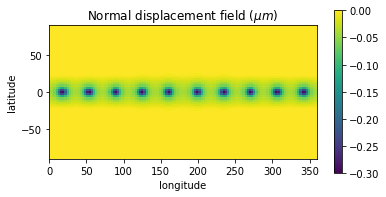

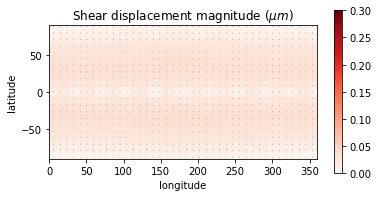

In [6]:
if plot_figure:
    fig, ax = visSHVec(U0vec*R, lmax_plot=lmax_plot, SphCoord=True, Complex=True, show=False,
                       config_quiver=(2, 3, 'k', 10), n_vrange=[-0.3, 0], s_vrange=[0, 0.3], lonshift=180, figsize=(6,3))
    ax[0].set_title('Normal displacement field ($\mu m$)')
    ax[1].set_title('Shear displacement magnitude ($\mu m$)')
    fig[0].savefig('ndisp.eps')
    fig[1].savefig('sdisp.eps')
    plt.show()

(61,) (121,)
(61, 122, 3)
[-0.04154335 -0.0414828  -0.04074764 -0.03969813 -0.04049747 -0.04076352
 -0.0402368  -0.03917823 -0.03962368 -0.04027529]
[-0.29230611 -0.29228082 -0.2894596  -0.28984577 -0.28807524 -0.28807524
 -0.28984577 -0.2894596  -0.29228082 -0.29230611]
-0.11848038582751656


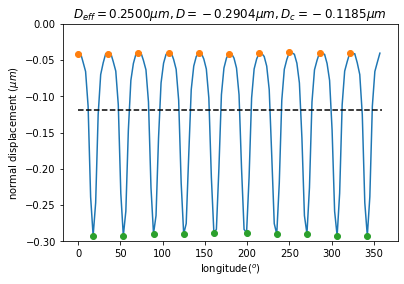

In [7]:
latitude, longitude = pyshtools.expand.GLQGridCoord(lJmax)
print(latitude.shape, longitude.shape)
U0mesh = SHVec2mesh(U0vec, Complex=True).real*R
print(U0mesh.shape)

deq  = U0mesh[latitude.size//2, :-1, 0]
topid= np.array([0, 12, 24, 36, 48, 60, 72, 84, 96, 108, ]).astype(int)
botid= np.array([6, 18, 30, 42, 54, 67, 79, 91,103, 115, ]).astype(int)
dtop = deq[topid]
dbot = deq[botid]
print(dtop)
print(dbot)

constriction = U0mesh[latitude.size//2, :-1, 0].mean()
print(constriction)

if plot_figure:
    plt.plot(longitude, deq)
    plt.plot(longitude[topid], deq[topid], 'o')
    plt.plot(longitude[botid], deq[botid], 'o')
    plt.plot([0,360], np.ones(2)*constriction, '--k')
    plt.xlabel('longitude($^o$)')
    plt.ylabel(r'normal displacement ($\mu m$)')
    plt.title(r'$D_{eff} = %.4f \mu m, D = %.4f \mu m, D_c = %.4f \mu m$'%(dtop.mean()-dbot.mean(), dbot.mean(), constriction))
    plt.ylim([-.3, 0])
    plt.show()

In [8]:
umesh_fine_scaled = SHVec2mesh(U0vec, lmax=lmax_plot, SphCoord=False, Complex=True)
tmesh_fine = SHVec2mesh(T0vec*mu0, lmax=lmax_plot, SphCoord=False, Complex=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


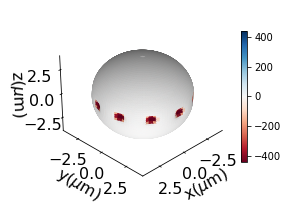

In [9]:
if plot_figure:
    fig, ax = visSH3d(umesh_fine_scaled, cmesh=tmesh_fine, r0=R, show=False, colorbar=True,
                      elevation=30, azimuth=45, surface=True, figsize=plt.figaspect(1))
    ax.grid(None)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.set_xlabel(r'x($\mu$m)', fontsize=16)
    ax.set_ylabel(r'y($\mu$m)', fontsize=16)
    ax.set_zlabel(r'z($\mu$m)', fontsize=16)
#     fig.tight_layout()
    fig.savefig('indent.pdf', dpi=300, transparent=True)
    fig.savefig('indent.eps', dpi=300, transparent=True)
    fig.savefig('indent.png', dpi=300, transparent=True)
    plt.show()